In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    pairwise_distances,
)
from tqdm import tqdm

seed = 42
import random


from collections import defaultdict

import sys

from tqdm import tqdm

sys.path.append("/home/jupyter/work/resources/DiplomDimReduction/")
import importlib
import torch
import config

importlib.reload(config)
import utils
from config import config_dict

importlib.reload(utils)

from utils import Autoencoder, LinearAutoencoder, load_sk_model, load_vectors, load_mapping

In [2]:
corpus_prefix = config_dict["marco_prefix"]
split_suffix = config_dict["train_suffix"]

In [3]:
# method_prefix = config_dict["dpr_prefix"]
# method_prefix = config_dict["ance_prefix"]
method_prefix = config_dict['tas-b_prefix']
# method_prefix = config_dict['s-bert_prefix']
# method_prefix = config_dict["late interaction prefix"]

corpus_vector_path = config_dict["corpus_vector_template"].format(
    corpus_prefix, method_prefix, split_suffix
)

corpus_sample_vector_path = config_dict["corpus_sample_vector_template"].format(
    corpus_prefix, method_prefix, split_suffix
)

corpus_mapping_path = config_dict["corpus_mapping_template"].format(
    corpus_prefix, method_prefix, split_suffix
)

sk_model_path_template = config_dict["reduction_sk_model_template"]
ae_model_path_template = config_dict["reduction_ae_model_template"]

In [4]:
curr_dim = 128

In [5]:
%%time
corpus_vectors = load_vectors(corpus_vector_path)
corpus_vectors.shape

CPU times: user 2 s, sys: 161 ms, total: 2.16 s
Wall time: 2.15 s


(99441, 768)

In [6]:
def reduct_sk(corpus_embeds, model_name, red_dim):
    model_path = sk_model_path_template.format(
        corpus_prefix, method_prefix, model_name, red_dim
    )
    red_model = load_sk_model(model_path)
    red_embeddings = red_model.transform(corpus_embeds)
    return red_embeddings

In [7]:
pca_vectors = reduct_sk(corpus_vectors, "PCA", curr_dim)

In [8]:
umap_vectors = reduct_sk(corpus_vectors, "UMAP", curr_dim)

2025-06-01 09:43:23.897893: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 09:43:23.960811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 09:43:25.101916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
umap_5_vectors = reduct_sk(corpus_vectors, "UMAP_5", curr_dim)

In [10]:
umap_25_vectors = reduct_sk(corpus_vectors, "UMAP_25", curr_dim)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
name2model = {
    "LinearAutoencoder": LinearAutoencoder,
    "AutoEncoder+": Autoencoder,
}

In [13]:
def reduct_ae(corpus_embeds, model_name, red_dim, model_kwargs={}):
    model_class = name2model[model_name]
    red_model = model_class(
        input_dim=corpus_embeds.shape[1], output_dim=red_dim, **model_kwargs
    )
    model_path = ae_model_path_template.format(
        corpus_prefix, method_prefix, model_name, red_dim
    )
    print(model_path)
    red_model.load_state_dict(torch.load(model_path, map_location=device))
    red_model.to(device)
    red_model.eval()
    with torch.no_grad():
        red_embeddings = red_model.encoder(
            torch.tensor(corpus_embeds, dtype=torch.float32)).numpy()
    return red_embeddings

In [14]:
lae_vectors = reduct_ae(corpus_vectors, "LinearAutoencoder", curr_dim)

/home/jupyter/work/resources/DiplomDimReduction/data/models/marco/tas_b/LinearAutoencoder_128.pt


In [15]:
ae_vectors = reduct_ae(corpus_vectors, "AutoEncoder+", curr_dim)

/home/jupyter/work/resources/DiplomDimReduction/data/models/marco/tas_b/AutoEncoder+_128.pt


# Тесты

In [16]:
np.random.seed(42)
sample_size = 10000
indices = np.random.choice(corpus_vectors.shape[0], sample_size, replace=False)

In [17]:
orig_vectors = corpus_vectors[indices]
pca_vectors = pca_vectors[indices]
umap_vectors = umap_vectors[indices]
umap_5_vectors = umap_5_vectors[indices]
umap_25_vectors = umap_25_vectors[indices]
lae_vectors = lae_vectors[indices]
ae_vectors = ae_vectors[indices]

## Корреляции

In [18]:
def flatten_distance_matrix(D):
    tril_indices = np.tril_indices_from(D, k=-1)
    return D[tril_indices]

In [19]:
D_orig = flatten_distance_matrix(pairwise_distances(orig_vectors, metric="euclidean"))
D_pca = flatten_distance_matrix(pairwise_distances(pca_vectors, metric="euclidean"))
D_umap = flatten_distance_matrix(pairwise_distances(umap_vectors, metric="euclidean"))
D_umap_5 = flatten_distance_matrix(pairwise_distances(umap_5_vectors, metric="euclidean"))
D_umap_25 = flatten_distance_matrix(pairwise_distances(umap_25_vectors, metric="euclidean"))
D_lae = flatten_distance_matrix(pairwise_distances(lae_vectors, metric="euclidean"))
D_ae = flatten_distance_matrix(pairwise_distances(ae_vectors, metric="euclidean"))

In [20]:
def check_spearman(D_orig, D_new):
    # Корреляция Спирмена
    corr, p_value = spearmanr(D_orig, D_new)
    print(
    f"Spearman correlation between distance matrices: {corr:.4f} (p-value={p_value:.4e})"
    )

In [21]:
check_spearman(D_orig, D_pca)

Spearman correlation between distance matrices: 0.8691 (p-value=0.0000e+00)


In [22]:
check_spearman(D_orig, D_umap)

Spearman correlation between distance matrices: 0.2494 (p-value=0.0000e+00)


In [23]:
check_spearman(D_orig, D_umap_5)

Spearman correlation between distance matrices: 0.2477 (p-value=0.0000e+00)


In [24]:
check_spearman(D_orig, D_umap_25)

Spearman correlation between distance matrices: 0.2545 (p-value=0.0000e+00)


In [25]:
check_spearman(D_orig, D_lae)

Spearman correlation between distance matrices: 0.8689 (p-value=0.0000e+00)


In [26]:
check_spearman(D_orig, D_ae)

Spearman correlation between distance matrices: 0.6680 (p-value=0.0000e+00)


## Кластеры

In [27]:
# inertia = []
# ks = range(3, 10)
# for k in tqdm(ks):
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(orig_vectors)
#     inertia.append(kmeans.inertia_)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 14%|█▍        | 1/7 [00:04<00:26,  4.45s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 29%|██▊       | 2/7 [00:08<00:22,  4.46s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 43%|████▎     | 3/7 [00:14<00:19,  4.86s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

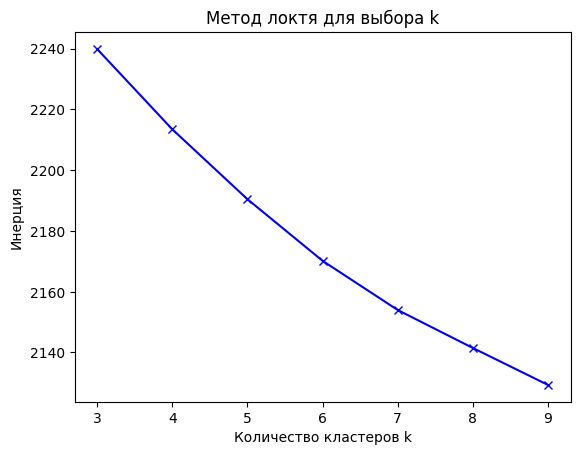

In [28]:
# plt.plot(ks, inertia, "bx-")
# plt.xlabel("Количество кластеров k")
# plt.ylabel("Инерция")
# plt.title("Метод локтя для выбора k")
# plt.show()

In [29]:
k = 6

In [30]:
kmeans_orig = KMeans(n_clusters=k, random_state=42).fit(orig_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
kmeans_pca = KMeans(n_clusters=k, random_state=42).fit(pca_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
kmeans_umap = KMeans(n_clusters=k, random_state=42).fit(umap_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
kmeans_umap_5 = KMeans(n_clusters=k, random_state=42).fit(umap_5_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
kmeans_umap_25 = KMeans(n_clusters=k, random_state=42).fit(umap_25_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [35]:
kmeans_lae = KMeans(n_clusters=k, random_state=42).fit(lae_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [36]:
kmeans_ae = KMeans(n_clusters=k, random_state=42).fit(ae_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
def check_kmeans(kmeans_orig, kmeans_red):  
    labels_orig = kmeans_orig.labels_
    labels_red = kmeans_red.labels_
    
    ari = adjusted_rand_score(labels_orig, labels_red)
    nmi = normalized_mutual_info_score(labels_orig, labels_red)
    
    print(f"Adjusted Rand Index (ARI) between clusterings: {ari:.4f}")
    print(f"Normalized Mutual Information (NMI) between clusterings: {nmi:.4f}")

* ARI > 0.7 и NMI > 0.7 — очень хорошее совпадение, глобальная структура почти полностью сохранена.
* ARI ≈ 0.4–0.7, NMI ≈ 0.4–0.7 — умеренное совпадение, часть глобальной структуры сохранена, но есть и искажения.
* ARI < 0.4, NMI < 0.4 — слабое совпадение, глобальная структура практически не сохранена.

In [38]:
check_kmeans(kmeans_orig, kmeans_pca)

Adjusted Rand Index (ARI) between clusterings: 0.9771
Normalized Mutual Information (NMI) between clusterings: 0.9638


In [39]:
check_kmeans(kmeans_orig, kmeans_umap)

Adjusted Rand Index (ARI) between clusterings: 0.1493
Normalized Mutual Information (NMI) between clusterings: 0.2439


In [40]:
check_kmeans(kmeans_orig, kmeans_umap_5)

Adjusted Rand Index (ARI) between clusterings: 0.1598
Normalized Mutual Information (NMI) between clusterings: 0.2518


In [41]:
check_kmeans(kmeans_orig, kmeans_umap_25)

Adjusted Rand Index (ARI) between clusterings: 0.1526
Normalized Mutual Information (NMI) between clusterings: 0.2492


In [42]:
check_kmeans(kmeans_orig, kmeans_lae)

Adjusted Rand Index (ARI) between clusterings: 0.8129
Normalized Mutual Information (NMI) between clusterings: 0.7947


In [43]:
check_kmeans(kmeans_orig, kmeans_ae)

Adjusted Rand Index (ARI) between clusterings: 0.4156
Normalized Mutual Information (NMI) between clusterings: 0.4957


### Сами кластеры

In [44]:
# texts = [corpus_mapping['i2text'][str(i)] for i in indices]

In [45]:
def get_clusters(kmeans):
    clusters = defaultdict(list)

    labels = kmeans.labels_
    for doc, label in zip(texts, labels):
        clusters[label].append(doc)
        
    for cluster_id, docs_in_cluster in clusters.items():
        print(f"Кластер {cluster_id} (всего {len(docs_in_cluster)} документов):")
        for doc in random.sample(docs_in_cluster, 5):
            print(f"  - {doc}")
        print()
        
    return clusters

In [46]:
# orig_clusters = get_clusters(kmeans_orig)

In [47]:
8

8